In [5]:
!pip install --upgrade vocos encodec librosa safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nv

In [3]:
import pprint
import IPython.display as ipd
import torch
import librosa

In [6]:
# load model
mars5, config_class = torch.hub.load('Camb-ai/mars5-tts', 'mars5_english', trust_repo=True)

Using cache found in /root/.cache/torch/hub/Camb-ai_mars5-tts_master
100%|██████████| 1.42G/1.42G [00:08<00:00, 173MB/s]
100%|██████████| 863M/863M [00:06<00:00, 145MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100%|██████████| 88.9M/88.9M [00:00<00:00, 113MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/lo

config.yaml:   0%|          | 0.00/503 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/40.4M [00:00<?, ?B/s]

In [7]:
type(config_class())

inference.InferenceConfig

In [ ]:
class InferenceConfig:
    def __init__(self, temperature=0.7, top_k=200, top_p=0.2, typical_p=1.0, freq_penalty=3, presence_penalty=0.4, rep_penalty_window=80, eos_penalty_decay=0.5, eos_penalty_factor=1, eos_estimated_gen_length_factor=1.0, timesteps=200, x_0_temp=0.7, q0_override_steps=20, nar_guidance_w=3, max_prompt_dur=12, generate_max_len_override=-1, deep_clone=True, use_kv_cache=True, trim_db=27, beam_width=1, ref_audio_pad=0):
        self.temperature = temperature
        self.top_k = top_k
        self.top_p = top_p
        self.typical_p = typical_p
        self.freq_penalty = freq_penalty
        self.presence_penalty = presence_penalty
        self.rep_penalty_window = rep_penalty_window
        self.eos_penalty_decay = eos_penalty_decay
        self.eos_penalty_factor = eos_penalty_factor
        self.eos_estimated_gen_length_factor = eos_estimated_gen_length_factor
        self.timesteps = timesteps
        self.x_0_temp = x_0_temp
        self.q0_override_steps = q0_override_steps
        self.nar_guidance_w = nar_guidance_w
        self.max_prompt_dur = max_prompt_dur
        self.generate_max_len_override = generate_max_len_override
        self.deep_clone = deep_clone
        self.use_kv_cache = use_kv_cache
        self.trim_db = trim_db
        self.beam_width = beam_width
        self.ref_audio_pad = ref_audio_pad


Now that the model is loaded, pick a reference audio to clone from. If you want to use deep clone, also specify its transcript.

In [8]:
# download example ref audio
!wget -O example.wav https://github.com/Camb-ai/mars5-tts/raw/master/docs/assets/example_ref.wav

--2024-07-16 17:36:25--  https://github.com/Camb-ai/mars5-tts/raw/master/docs/assets/example_ref.wav
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Camb-ai/mars5-tts/master/docs/assets/example_ref.wav [following]
--2024-07-16 17:36:25--  https://raw.githubusercontent.com/Camb-ai/mars5-tts/master/docs/assets/example_ref.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137392 (134K) [audio/wav]
Saving to: ‘example.wav’

example.wav         100%[===================>] 134.17K  --.-KB/s    in 0.03s   

2024-07-16 17:36:25 (5.20 MB/s) - ‘example.wav’ saved [137392/137392]



In [9]:
wav, sr = librosa.load('./example.wav',
                       sr=mars5.sr, mono=True)
wav = torch.from_numpy(wav)
ref_transcript = "We actually haven't managed to meet demand."
print("Reference audio:")
ipd.display(ipd.Audio(wav.numpy(), rate=mars5.sr))
print(f"Reference transcript: {ref_transcript}")

Reference audio:


Reference transcript: We actually haven't managed to meet demand.


In [10]:
config_class()

InferenceConfig(temperature=0.7, top_k=200, top_p=0.2, typical_p=1.0, freq_penalty=3, presence_penalty=0.4, rep_penalty_window=80, eos_penalty_decay=0.5, eos_penalty_factor=1, eos_estimated_gen_length_factor=1.0, timesteps=200, x_0_temp=0.7, q0_override_steps=20, nar_guidance_w=3, max_prompt_dur=12, generate_max_len_override=-1, deep_clone=True, use_kv_cache=True, trim_db=27, beam_width=1, ref_audio_pad=0)

In [ ]:
deep_clone = True # set to False if you don't know prompt transcript or want fast inference.
# Below you can tune other inference settings, like top_k, temperature, top_p, etc...
cfg = config_class(deep_clone=deep_clone, rep_penalty_window=100,
                      top_k=100, temperature=0.7, freq_penalty=3)

ar_codes, wav_out = mars5.tts("The quick brown rat.", wav,
          ref_transcript,
          cfg=cfg)

print('Synthesized output audio:')
ipd.Audio(wav_out.numpy(), rate=mars5.sr)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Note: using deep clone. Assuming input `c_phones` is concatenated prompt and output phones. Also assuming no padded indices in `c_codes`.
New x: torch.Size([1, 677, 8]) | new x_known: torch.Size([1, 677, 8]) . Base prompt: torch.Size([1, 215, 8]). New padding mask: torch.Size([1, 677]) | m shape: torch.Size([1, 677, 8])
Synthesized output audio:


In [ ]:
deep_clone = False # set to False if you don't know prompt transcript or want fast inference.
# Below you can tune other inference settings, like top_k, temperature, top_p, etc...
cfg = config_class(deep_clone=deep_clone, rep_penalty_window=100,
                      top_k=100, temperature=0.7, freq_penalty=3)

ar_codes, wav_out = mars5.tts("The quick brown rat.", wav,
          ref_transcript,
          cfg=cfg)

print('Synthesized output audio:')
ipd.Audio(wav_out.numpy(), rate=mars5.sr)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Synthesized output audio:


You can see all the inference settings available to tune in the inference config here:

In [11]:
pprint.pprint(config_class())

InferenceConfig(temperature=0.7,
                top_k=200,
                top_p=0.2,
                typical_p=1.0,
                freq_penalty=3,
                presence_penalty=0.4,
                rep_penalty_window=80,
                eos_penalty_decay=0.5,
                eos_penalty_factor=1,
                eos_estimated_gen_length_factor=1.0,
                timesteps=200,
                x_0_temp=0.7,
                q0_override_steps=20,
                nar_guidance_w=3,
                max_prompt_dur=12,
                generate_max_len_override=-1,
                deep_clone=True,
                use_kv_cache=True,
                trim_db=27,
                beam_width=1,
                ref_audio_pad=0)


You can also listen to the vocoded raw coarse codes, for debugging purposes:

Created a dataframe of all the parameters used in tts model and added a column in which for now i labelled the audio generated as natural or robotic.

In [1]:
import pandas as pd

In [13]:
import pandas as pd

# Data to be converted to a dataframe
data = {
    "temperature": [0.7],
    "top_k": [200],
    "top_p": [0.2],
    "typical_p": [1.0],
    "freq_penalty": [3],
    "presence_penalty": [0.4],
    "rep_penalty_window": [80],
    "eos_penalty_decay": [0.5],
    "eos_penalty_factor": [1],
    "eos_estimated_gen_length_factor": [1.0],
    "timesteps": [200],
    "x_0_temp": [0.7],
    "q0_override_steps": [20],
    "nar_guidance_w": [3],
    "max_prompt_dur": [12],
    "generate_max_len_override": [-1],
    "deep_clone": [True],
    "use_kv_cache": [True],
    "trim_db": [27],
    "beam_width": [1],
    "ref_audio_pad": [0]
}

# Create the dataframe
df = pd.DataFrame(data)

# Add the final column
df["audio_type"] = "natural"  # or "robotic" depending on the criteria

# Display the dataframe
print(df)


   temperature  top_k  top_p  typical_p  freq_penalty  presence_penalty  \
0          0.7    200    0.2        1.0             3               0.4   

   rep_penalty_window  eos_penalty_decay  eos_penalty_factor  \
0                  80                0.5                   1   

   eos_estimated_gen_length_factor  ...  q0_override_steps  nar_guidance_w  \
0                              1.0  ...                 20               3   

   max_prompt_dur  generate_max_len_override  deep_clone  use_kv_cache  \
0              12                         -1        True          True   

   trim_db  beam_width  ref_audio_pad  audio_type  
0       27           1              0     natural  

[1 rows x 22 columns]


# Explanation of LIME and SHAP in Python

## LIME Explanation Plot

LIME (Local Interpretable Model-agnostic Explanations) provides local explanations for individual predictions made by machine learning models.

### Explanation:
The LIME explanation plot (`lime_exp.show_in_notebook(show_table=True)`) visualizes how specific features contribute to the prediction for a single instance (`X_test.iloc[0]`). It uses a simplified, interpretable model (e.g., linear model) to approximate the behavior of the complex underlying model. This plot typically includes:
- **Feature Contributions**: Shows which features influence the prediction and to what extent.
- **Local Model Explanation**: Explains how the local model interprets the relationship between features and the predicted outcome.
- **Interpretability**: Helps users understand why a particular prediction was made by highlighting key contributing factors in a human-readable format.

## SHAP Decision Plot

SHAP (SHapley Additive exPlanations) explains the output of machine learning models by attributing the prediction to each feature.

### Explanation:
The SHAP decision plot (`shap.decision_plot(explainer.expected_value, shap_values, X_test, show=True)`) visualizes the impact of each feature on an individual prediction (`X_test`). Key details include:
- **Feature Importance**: Illustrates how each feature contributes positively or negatively to the final prediction.
- **Interpretability**: Provides a clear breakdown of feature contributions, helping users understand the decision-making process of the model.
- **Expected Value**: Represents the base value of the model's prediction before considering the effects of each feature, providing context for the overall prediction.

## SHAP Summary Plot

SHAP summary plots provide an overview of feature importance across multiple predictions made by the model.

### Explanation:
The SHAP summary plot (`shap.summary_plot(shap_values, X_test, show=True)`) aggregates the impact of each feature across all instances in `X_test`. It includes:
- **Global Feature Importance**: Ranks features based on their cumulative influence on model predictions across the dataset.
- **Feature Interaction**: Shows how pairs of features interact to influence predictions, highlighting complex relationships that impact model outcomes.
- **Insights into Model Behavior**: Offers insights into which features consistently drive predictions, aiding in understanding model behavior and identifying important variables in the dataset.


In [14]:
import pandas as pd
import numpy as np

# Initial data to be converted to a dataframe
data = {
    "temperature": [0.7],
    "top_k": [200],
    "top_p": [0.2],
    "typical_p": [1.0],
    "freq_penalty": [3],
    "presence_penalty": [0.4],
    "rep_penalty_window": [80],
    "eos_penalty_decay": [0.5],
    "eos_penalty_factor": [1],
    "eos_estimated_gen_length_factor": [1.0],
    "timesteps": [200],
    "x_0_temp": [0.7],
    "q0_override_steps": [20],
    "nar_guidance_w": [3],
    "max_prompt_dur": [12],
    "generate_max_len_override": [-1],
    "deep_clone": [True],
    "use_kv_cache": [True],
    "trim_db": [27],
    "beam_width": [1],
    "ref_audio_pad": [0],
    "audio_type": ["natural"]
}

# Create the initial dataframe
df = pd.DataFrame(data)

# Function to generate a random sample
def generate_random_sample():
    return {
        "temperature": np.random.uniform(0.5, 1.0),
        "top_k": np.random.randint(100, 300),
        "top_p": np.random.uniform(0.1, 1.0),
        "typical_p": np.random.uniform(0.5, 1.0),
        "freq_penalty": np.random.randint(1, 5),
        "presence_penalty": np.random.uniform(0.0, 1.0),
        "rep_penalty_window": np.random.randint(50, 100),
        "eos_penalty_decay": np.random.uniform(0.1, 1.0),
        "eos_penalty_factor": np.random.randint(0, 2),
        "eos_estimated_gen_length_factor": np.random.uniform(0.5, 1.5),
        "timesteps": np.random.randint(100, 300),
        "x_0_temp": np.random.uniform(0.5, 1.0),
        "q0_override_steps": np.random.randint(10, 30),
        "nar_guidance_w": np.random.randint(1, 5),
        "max_prompt_dur": np.random.randint(5, 20),
        "generate_max_len_override": np.random.randint(-2, 2),
        "deep_clone": np.random.choice([True, False]),
        "use_kv_cache": np.random.choice([True, False]),
        "trim_db": np.random.randint(20, 30),
        "beam_width": np.random.randint(1, 5),
        "ref_audio_pad": np.random.randint(0, 2),
        "audio_type": np.random.choice(["natural", "robotic"])
    }

# Add 10 random samples to the dataframe
random_samples = [generate_random_sample() for _ in range(10)]
df = pd.concat([df, pd.DataFrame(random_samples)], ignore_index=True)

# Display the dataframe
print(df)


    temperature  top_k     top_p  typical_p  freq_penalty  presence_penalty  \
0      0.700000    200  0.200000   1.000000             3          0.400000   
1      0.927036    179  0.405225   0.590952             1          0.018838   
2      0.703648    268  0.681920   0.792871             2          0.937336   
3      0.996149    111  0.723364   0.691077             2          0.353670   
4      0.835934    291  0.643747   0.932185             2          0.018809   
5      0.620102    146  0.181777   0.715882             3          0.395431   
6      0.977613    259  0.291042   0.622927             1          0.748969   
7      0.532258    105  0.716261   0.742422             3          0.704921   
8      0.543195    289  0.624709   0.783171             3          0.767492   
9      0.975111    130  0.836923   0.921480             4          0.086994   
10     0.939732    241  0.543875   0.862756             1          0.591748   

    rep_penalty_window  eos_penalty_decay  eos_pena

In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import shap

In [17]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 7.9 MB/s eta 0:00:00


In [19]:
# Encode 'audio_type' as numerical for model fitting
df['audio_type'] = df['audio_type'].map({'natural': 0, 'robotic': 1})

# Split the data into features and target
X = df.drop("audio_type", axis=1)
y = df["audio_type"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [20]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [37]:
import lime
from lime import lime_tabular

In [32]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=07648032b4f6eedb3ad12eb7deb9f85f5925905d43f94df99508d1bf143b51e1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [40]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [42]:
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['natural', 'robotic'], discretize_continuous=True)
lime_exp = lime_explainer.explain_instance(X_test.iloc[0].values, model.predict_proba, num_features=10)
lime_exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


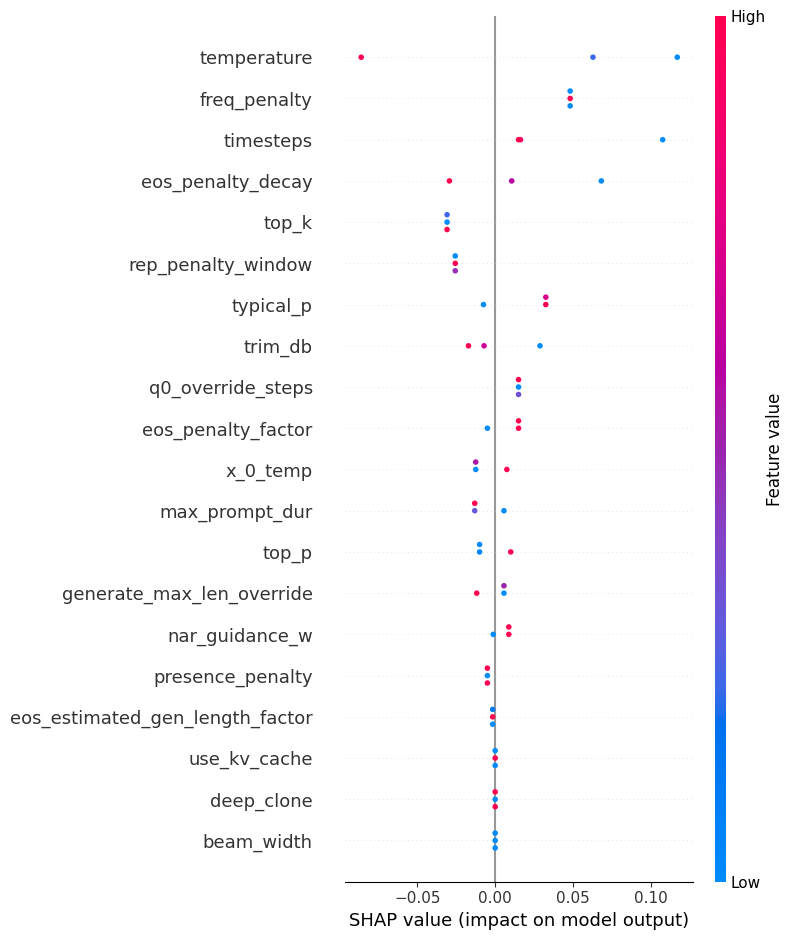

In [43]:
shap.summary_plot(shap_values, X_test, show=True)
# plt.savefig('shap_summary_plot.png')


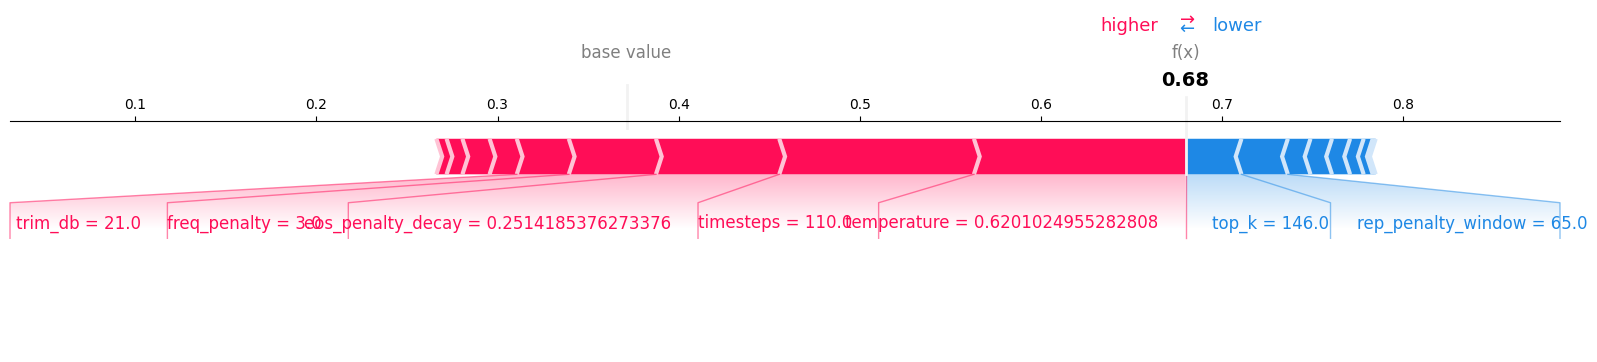

In [51]:
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], show=True, matplotlib=True)

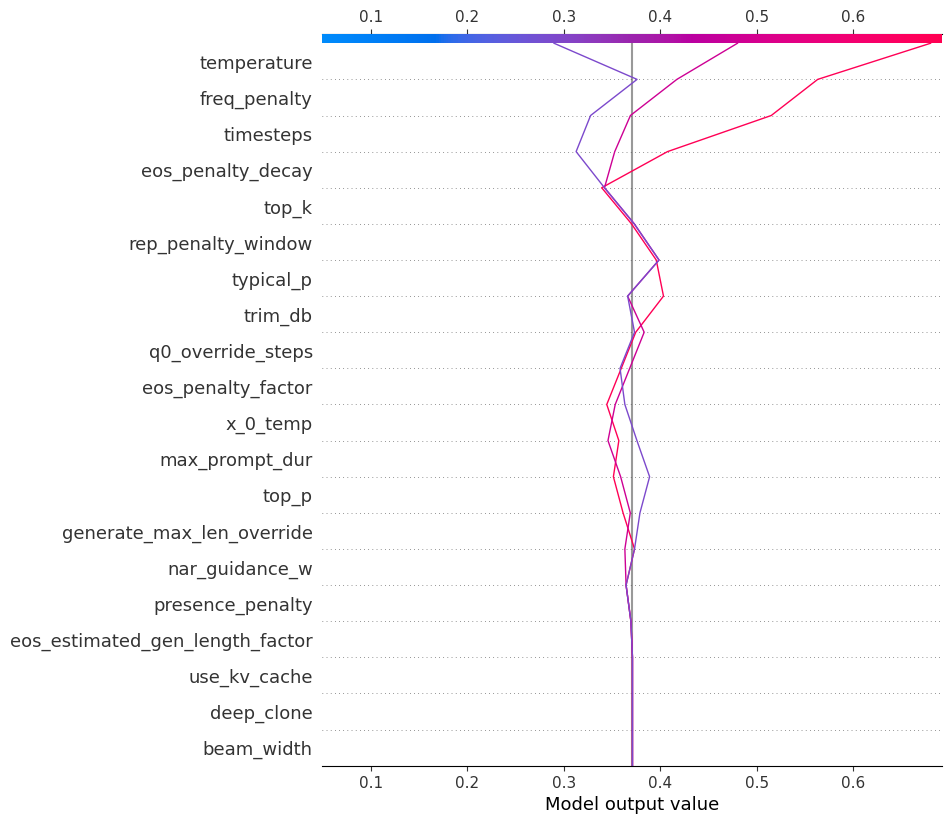

In [50]:
shap.decision_plot(explainer.expected_value, shap_values, X_test, show=True)
# plt.savefig('shap_decision_plot.png')

## Using this tool of explainability AI Engineers can see which factors most affect the quality of audio and can tweak those factors. This data is just dummy. To label the audio as natural or robotic we need to build a audio analysis model.
